In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
import os, datetime, sys 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from zipfile import ZipFile
from tqdm import tqdm
import warnings 
warnings.filterwarnings("ignore")
import random
import cv2
from sklearn.model_selection import KFold
from imgaug import augmenters as ia
import glob, sys, json, urllib
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Flatten, Concatenate, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%%time
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet1.zip' 
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet2.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet3.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet4.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet5.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet6.zip'
!unzip -qq '/content/drive/MyDrive/fashion_data/triplet/images_triplet7.zip'

CPU times: user 3.7 s, sys: 800 ms, total: 4.5 s
Wall time: 11min 10s


In [7]:
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/final_triplet.csv') ### load final_triplet.csv file
image_path = 'images_triplet/'
meta_df_new.drop(columns = ['level_0', 'index'], inplace = True)
meta_df_new.head()

,type,category,street_photo_id,product_id,width,top,height,left,shop_photo_id,street_photo_url,shop_photo_url,is_selected
0,train,dresses,10222,28493,311,249,594,282,55399,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1
1,train,skirts,10878,3733,167,221,190,154,97361,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1
2,train,dresses,10585,47823,840,970,1415,665,40225,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1
3,test,footwear,9760,24120,80,977,131,290,23712,http://media1.modcloth.com/community_outfit_im...,http://productshots2.modcloth.net/productshots...,1
4,train,dresses,1691,25753,534,1023,1040,869,58474,http://media1.modcloth.com/community_outfit_im...,http://productshots0.modcloth.net/productshots...,1


We are here creating three columns anchor_path (path to the anchor image), pos_path (path to the positive image), neg_path(path to the negative image), neg_path creation is little tricky to get negative path of some rowX in df I am first creating temp_df this df contains all rows except the rows belonging category of rowX then from temp_df I am taking anchor path of any row and setting it as neg_path of rowX.

In [ ]:
%%time
meta_df_new['anchor_path'] = image_path + meta_df_new['street_photo_id'].apply(lambda x : str(x)) + '.jpg'
meta_df_new['pos_path'] = image_path + meta_df_new['shop_photo_id'].apply(lambda x :str(x)) + '.jpg'

meta_df_new['x1'] = meta_df_new['left']
meta_df_new['y1'] = meta_df_new['top']
meta_df_new['x2'] = meta_df_new['left'] + meta_df_new['width']
meta_df_new['y2'] = meta_df_new['top'] + meta_df_new['height']

neg_path = []
for i in range(len(meta_df_new)) :
    cat = meta_df_new.iloc[i]['category']
    temp_df = meta_df_new[meta_df_new['category'] == cat]
    temp_df = shuffle(temp_df)
    ind = np.random.randint(0, len(temp_df) - 1)
    neg_path_temp = str(temp_df.iloc[ind]['pos_path'])
    neg_path.append(neg_path_temp)

meta_df_new['neg_path'] = neg_path

CPU times: user 12min 46s, sys: 8.79 s, total: 12min 55s
Wall time: 12min 51s


In [ ]:
meta_df_new.to_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_noncorrupt.csv')

In [8]:
meta_df_new = pd.read_csv('/content/drive/MyDrive/fashion_data/triplet/triplet_noncorrupt.csv') ## reading the saved file
image_path = 'images_triplet/'
train_df, val_df = train_test_split(meta_df_new, test_size = 0.25, random_state = 33) ## train test split

###Data Pipeline

In [23]:
EMBED_SIZE = 100         ### Change Later
IMAGE_SIZE = 256
BATCH_SIZE = 24
MARGIN = 1
LR = 0.01 
#ALPHA = 5e-5
#TAU = (1 / (3 * EMBED_SIZE))

class Dataset :
    def __init__(self, df, aug_flag = False) :
        self.data = df
        self.aug_flag = aug_flag
        self.aug1 = ia.Dropout(p=0.01)
        self.aug2 = ia.GaussianBlur(sigma=(0.0, 3.0))
        self.aug3 = ia.flip.Fliplr(0.8)
        self.aug4 = ia.flip.Flipud(0.8)
        self.aug5 = ia.Alpha((0.0, 1.0), ia.AllChannelsHistogramEqualization())
        
    def __getitem__(self, i) :
        row = self.data.iloc[i]
        anchor_path = row['anchor_path']
        pos_path = row['pos_path']
        neg_path = row['neg_path']   ## change after testing pos to neg
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']

        anchor_img = cv2.imread(anchor_path)
        anchor_img = cv2.cvtColor(src = anchor_img, code = cv2.COLOR_BGR2RGB)

        pos_img = cv2.imread(pos_path)
        pos_img = cv2.cvtColor(src = pos_img, code = cv2.COLOR_BGR2RGB)

        neg_img = cv2.imread(neg_path)
        neg_img = cv2.cvtColor(src = neg_img, code = cv2.COLOR_BGR2RGB)

        anchor_img = anchor_img[y1:y2 + 1, x1:x2 + 1, :] ## crop image using bounding 
        anchor_img = cv2.resize(anchor_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST) ## resize it
        pos_img = cv2.resize(pos_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST)
        neg_img = cv2.resize(neg_img, (IMAGE_SIZE, IMAGE_SIZE), cv2.INTER_NEAREST)

        if self.aug_flag :
            a = np.random.uniform()
            if a < 0.4 :
                b = np.random.uniform()
                if b < 0.2 :
                    anchor_img = self.aug1.augment_image(anchor_img)
                    pos_img = self.aug1.augment_image(pos_img)
                    neg_img = self.aug1.augment_image(neg_img)

                elif b < 0.4:
                    anchor_img = self.aug2.augment_image(anchor_img)
                    pos_img = self.aug2.augment_image(pos_img)
                    neg_img = self.aug2.augment_image(neg_img)

                elif b < 0.6:
                    anchor_img = self.aug3.augment_image(anchor_img)
                    pos_img = self.aug3.augment_image(pos_img)
                    neg_img = self.aug3.augment_image(neg_img)

                elif b < 0.8:
                    anchor_img = self.aug4.augment_image(anchor_img)
                    pos_img = self.aug4.augment_image(pos_img)
                    neg_img = self.aug4.augment_image(neg_img)
                
                elif b < 1 :
                    anchor_img = self.aug5.augment_image(anchor_img)
                    pos_img = self.aug5.augment_image(pos_img)
                    neg_img = self.aug5.augment_image(neg_img)

        #print(anchor_img.shape, pos_img.shape, neg_img.shape)
        return anchor_img.astype('float32'), pos_img.astype('float32'), neg_img.astype('float32'), row['category'], row['pos_path'], row['anchor_path']

    def __len__(self):
        return len(self.data)

class Dataloader(tf.keras.utils.Sequence) :
    def __init__(self, dataset, batch_size = 2, shuffle = False) :
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset))
        self.shuffle = shuffle
    
    def __getitem__(self, ind) :
        anchor_list = []
        pos_list = []
        neg_list = []
        for i in self.indexes[ind * self.batch_size : (ind + 1)*self.batch_size] :
            anchor, pos, neg, category, pos_path, anchor_path = self.dataset[i]
            anchor_list.append(anchor)
            pos_list.append(pos)
            neg_list.append(neg)
        
        anchor_array = np.stack(anchor_list, axis = 0)
        pos_array = np.stack(pos_list, axis = 0)
        neg_array = np.stack(neg_list, axis = 0)
        y = np.random.randint(low = 0, high = (EMBED_SIZE * 3) - 1, size=(self.batch_size, 1))      ## False output                                                                                   
        return ([anchor_array, pos_array, neg_array], y)

    def __len__(self): ## Number of batches we can generate
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle :
            self.indexes = np.random.permutation(self.indexes)


In [24]:
train_dataset = Dataset(train_df, aug_flag = True)
valid_dataset = Dataset(val_df)  

train_gen = Dataloader(train_dataset, BATCH_SIZE, shuffle = True)
valid_gen = Dataloader(valid_dataset, BATCH_SIZE, shuffle = True)

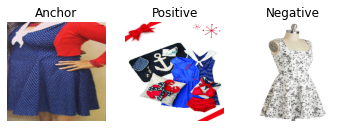

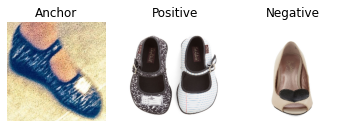

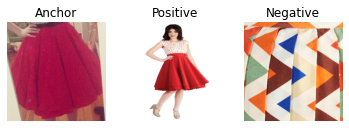

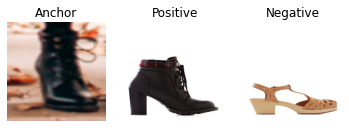

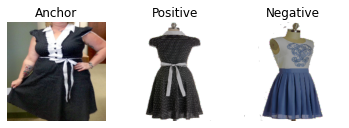

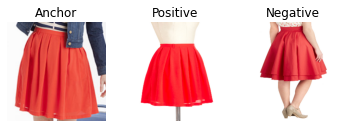

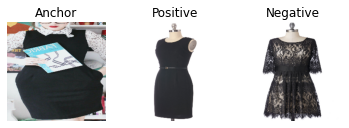

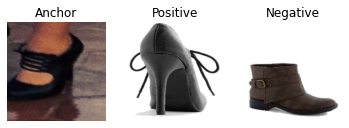

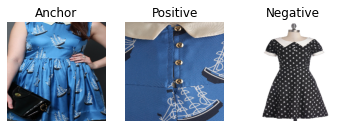

In [25]:
ind = np.random.randint(0, len(train_gen))
image_set = train_gen[ind][0]
anchor = image_set[0]
pos = image_set[1] 
neg = image_set[2]

for i in range(BATCH_SIZE) :
    fig, ax = plt.subplots(1, 3)
    ax[0].set_title('Anchor')
    ax[0].imshow(anchor[i].astype(int))
    ax[0].axis('off')
    ax[1].set_title('Positive')
    ax[1].imshow(pos[i].astype(int))
    ax[1].axis('off')
    ax[2].set_title('Negative')
    ax[2].imshow(neg[i].astype(int))
    ax[2].axis('off')
    if i == 8 :
        break

###Build Model

In [31]:
def triplet_loss(yactual, ypred) :
    anchor, pos, neg = ypred.read(0), ypred.read(1), ypred.read(2)
    anchor_pos = tf.sqrt(tf.reduce_sum(tf.square(anchor - pos), axis = -1))
    anchor_neg = tf.sqrt(tf.reduce_sum(tf.square(anchor - neg), axis = -1))
    zeros = tf.constant(0, dtype = tf.float32)
    Ltriplet = tf.math.maximum(zeros, MARGIN + (anchor_pos - anchor_neg))   ### change after testing reminder
    return tf.reduce_mean(Ltriplet)

In [32]:
class Triplet_Model(tf.keras.Model) :
    def __init__(self, resnet_obj, embedding_size = 32) :
        super(Triplet_Model, self).__init__()
        self.embedding_size = embedding_size
        self.resnet_obj = resnet_obj
        self.dense1 = Dense(units = self.embedding_size)
        self.drop1 = Dropout(0.4)
        self.Lambda = Lambda(lambda  x : tf.keras.backend.l2_normalize(x,axis=1))
        
    def call(self, data) :
        anchor_img = data[0]
        pos_img = data[1]
        neg_img = data[2]

        anchor = self.resnet_obj(anchor_img) 
        neg = self.resnet_obj(neg_img)
        pos = self.resnet_obj(pos_img)

        anchor = self.drop1(anchor)
        neg = self.drop1(neg)
        pos = self.drop1(pos)

        anchor = self.dense1(anchor)
        neg = self.dense1(neg)
        pos = self.dense1(pos)

        anchor = self.Lambda(anchor)
        neg = self.Lambda(neg)
        pos = self.Lambda(pos)

        out_array  = tf.TensorArray(dtype = tf.float32, size = 3)
        out_array = out_array.write(0, anchor)
        out_array = out_array.write(1, pos)
        out_array = out_array.write(2, neg)
        return out_array

In [33]:
resnet_obj = ResNet50(include_top=False, weights='imagenet', pooling = 'max', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in resnet_obj.layers[0: 178 - 35] : # Train only last 35 layers
    layer.trainable = False

###Training

In [ ]:
%%time
LR = (LR /  1.25)
!rm -rf ./logs/
tf.keras.backend.clear_session()
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest1.hd5', \
                                                    monitor = 'val_loss', save_weights_only = True, save_best_only = True)

model = Triplet_Model(resnet_obj, embedding_size = EMBED_SIZE)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = LR), loss = triplet_loss)
model.fit(train_gen, epochs = 10, steps_per_epoch = 100,  validation_data = valid_gen, validation_steps = 40, callbacks = [model_checkpoint])

In [ ]:
%%time
for layer in resnet_obj.layers[178 - 45:] : # Train only last 45 layers
    layer.trainable = True

LR = (LR / 2.5)
!rm -rf ./logs/
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest2.hd5', \
                                                    monitor = 'val_loss', save_weights_only = True, save_best_only = True)

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf.keras.backend.set_value(model.optimizer.learning_rate, LR)
model.load_weights('/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest1.hd5')
model.fit(train_gen, epochs = 10, steps_per_epoch = 100,  validation_data = valid_gen, validation_steps = 40, callbacks = [model_checkpoint])

In [ ]:
%%time
for layer in resnet_obj.layers[178 - 55:] : # Train only last 55 layers
    layer.trainable = True

LR = (LR / 3)
!rm -rf ./logs/
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest3.hd5', \
                                                    monitor = 'val_loss', save_weights_only = True, save_best_only = True)

tf.keras.backend.set_value(model.optimizer.learning_rate, LR)
model.load_weights('/content/drive/MyDrive/fashion_data/triplet/triplet_weights_latest2.hd5')
model.fit(train_gen, epochs = 8, steps_per_epoch = 100,  validation_data = valid_gen, validation_steps = 40, callbacks = [model_checkpoint])